In [1]:
# Importing all the necessary libraries
import pandas as pd
from PIL import Image
import cv2
import numpy as np
from ultralytics import YOLO
import matplotlib.pyplot as plt
import os
from torchvision import transforms
import torch.nn as nn 
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import re
import pickle
import csv

In [3]:
# Import the co ordinates of bbox

data = pd.read_csv('/Users/velmurugan/Desktop/@/python_works/License plate detection/Licplatesdetection_train.csv')

In [3]:
data.head()

,img_id,ymin,xmin,ymax,xmax
0,1.jpg,276,94,326,169
1,10.jpg,311,395,344,444
2,100.jpg,406,263,450,434
3,101.jpg,283,363,315,494
4,102.jpg,139,42,280,222


In [4]:
# Settings to show all the rows in the dataframe

pd.set_option('display.max_rows', None)

In [4]:
# img_id column is not sorted 
# Function to extract numeric part from img_id to sort

def extract_numeric_part(img_id):
    
    return int(img_id.split('.')[0])

# Apply the function to create a new column for sorting
data['img_id_numeric'] = data['img_id'].apply(extract_numeric_part)

# Sort the DataFrame based on the numeric column
data = data.sort_values(by='img_id_numeric')

# Drop the numeric column it is not needed
data = data.drop(columns='img_id_numeric')

data.reset_index(drop=True, inplace=True)

print(data.head(3))
data.tail(3)


  img_id  ymin  xmin  ymax  xmax
0  1.jpg   276    94   326   169
1  2.jpg   297    96   324   209
2  3.jpg   525   216   547   397


,img_id,ymin,xmin,ymax,xmax
897,898.jpg,341,316,390,523
898,899.jpg,239,133,260,210
899,900.jpg,286,266,332,421


In [5]:
#getting the width and height of the image to convert xmin,ymin,xmax,ymax values to yolo format
#yolo format ==> x_center, y_center, width, height

def get_image_dimensions(image_path):
  
    with Image.open(image_path) as img:
        width, height = img.size
        return width, height

In [6]:
#converting the label csv file to txt format to train yolo model

def convert_csv_to_yolo(df, image_dir, label_dir, class_id):
  """
  Converts a CSV file with bounding box annotations to YOLO format.

  """
  
  for index, row in df.iterrows():
    image_name = row["img_id"]
    image_path = f"{image_dir}/{image_name}"
    
    ymin, xmin, ymax, xmax = row[["ymin", "xmin", "ymax", "xmax"]]
    
    # Get image width and height (you'll need to replace this with your method to get image dimensions)
    image_width, image_height = get_image_dimensions(image_path)
    
    # Calculate normalized center coordinates, width, and height
    x_center = (xmin + xmax) / (2 * image_width)
    y_center = (ymin + ymax) / (2 * image_height)
    width = (xmax - xmin) / image_width
    height = (ymax - ymin) / image_height
    
    # Create the YOLO format line
    yolo_line = f"{class_id} {x_center} {y_center} {width} {height}"
    
    # Write the line to a text file named after the image
    with open(f"{label_dir}/{(image_name.split('.'))[0]}.txt", "w") as f:
      f.write(yolo_line)


In [8]:
# I take the 1st 870 samples for training and last 30 samples for validation
# creating the train and validation label txt files

train_data = data.iloc[:870]
val_data = data.iloc[870:]

train_image_path ='/Users/velmurugan/Desktop/@/python_works/License plate detection/images/train'
train_label_path ='/Users/velmurugan/Desktop/@/python_works/License plate detection/labels/train'
val_image_path = '/Users/velmurugan/Desktop/@/python_works/License plate detection/images/val'
val_label_path = '/Users/velmurugan/Desktop/@/python_works/License plate detection/labels/val' 

convert_csv_to_yolo(data=train_data,image_dir=train_image_path,label_dir=train_label_path,class_id=0)
convert_csv_to_yolo(data=val_data,image_dir=val_image_path,label_dir=val_label_path,class_id=0)


In [10]:
# Load a pretrained model 
model = YOLO("yolov8n.pt")  

# Fine tune the model for our dataset
model.train(data='/Users/velmurugan/Desktop/@/python_works/License plate detection/config.yaml'
            ,epochs=20,
            batch=16)

Ultralytics YOLOv8.2.38 🚀 Python-3.12.0 torch-2.2.1 CPU (Apple M1)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/Users/velmurugan/Desktop/@/python_works/License plate detection/config.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train5, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_lab

train: Scanning /Users/velmurugan/Desktop/@/python_works/License plate detection/labels/train.cache... 870 images, 0 backgrounds, 0 corrupt: 100%|██████████| 870/870 [00:00<?, ?it/s]
val: Scanning /Users/velmurugan/Desktop/@/python_works/License plate detection/labels/val.cache... 30 images, 0 backgrounds, 0 corrupt: 100%|██████████| 30/30 [00:00<?, ?it/s]


Plotting labels to runs/detect/train5/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train5
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20         0G      1.191      2.209      1.078         10        640: 100%|██████████| 55/55 [08:35<00:00,  9.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<00:00,  9.11s/it]

                   all         30         30    0.00333          1      0.584      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20         0G      1.156      1.357       1.03         12        640: 100%|██████████| 55/55 [09:05<00:00,  9.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:10<00:00, 10.68s/it]

                   all         30         30          1      0.919      0.964      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20         0G      1.146       1.16      1.024         12        640: 100%|██████████| 55/55 [10:44<00:00, 11.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:10<00:00, 10.11s/it]

                   all         30         30          1      0.959      0.992      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20         0G       1.18      0.997      1.031         11        640: 100%|██████████| 55/55 [08:48<00:00,  9.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:08<00:00,  8.73s/it]

                   all         30         30          1      0.989      0.995      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20         0G       1.14     0.9036      1.021          8        640: 100%|██████████| 55/55 [08:33<00:00,  9.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:08<00:00,  8.75s/it]

                   all         30         30      0.997      0.967      0.965      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20         0G      1.062     0.7907      0.995          7        640: 100%|██████████| 55/55 [08:31<00:00,  9.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:08<00:00,  8.72s/it]

                   all         30         30      0.995      0.967      0.976      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20         0G      1.038       0.72     0.9873         14        640: 100%|██████████| 55/55 [08:32<00:00,  9.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:08<00:00,  8.77s/it]

                   all         30         30      0.964          1       0.99      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20         0G      1.008     0.6725     0.9701         14        640: 100%|██████████| 55/55 [08:33<00:00,  9.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:08<00:00,  8.73s/it]

                   all         30         30      0.992      0.967      0.993      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20         0G     0.9858     0.6449     0.9599         11        640: 100%|██████████| 55/55 [20:21<00:00, 22.21s/it]   
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:08<00:00,  8.78s/it]

                   all         30         30      0.995      0.967      0.993      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20         0G     0.9555     0.6186     0.9528          9        640: 100%|██████████| 55/55 [08:27<00:00,  9.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:08<00:00,  8.74s/it]

                   all         30         30      0.998          1      0.995      0.799


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20         0G     0.9263     0.5999     0.9392          6        640: 100%|██████████| 55/55 [08:20<00:00,  9.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:08<00:00,  8.79s/it]

                   all         30         30      0.966      0.967      0.984      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20         0G     0.9092     0.5643     0.9382          6        640: 100%|██████████| 55/55 [08:21<00:00,  9.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:08<00:00,  8.78s/it]

                   all         30         30       0.96          1      0.993      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20         0G     0.8933      0.545     0.9343          6        640: 100%|██████████| 55/55 [08:24<00:00,  9.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:08<00:00,  8.81s/it]

                   all         30         30      0.965          1      0.994      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20         0G     0.8871     0.5175     0.9229          6        640: 100%|██████████| 55/55 [08:24<00:00,  9.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:08<00:00,  8.79s/it]

                   all         30         30      0.998          1      0.995      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20         0G     0.8384     0.4891      0.917          5        640: 100%|██████████| 55/55 [08:25<00:00,  9.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:08<00:00,  8.76s/it]

                   all         30         30      0.996      0.967      0.992      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20         0G     0.8336     0.4742     0.9133          6        640: 100%|██████████| 55/55 [08:26<00:00,  9.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:08<00:00,  8.91s/it]

                   all         30         30      0.997          1      0.995      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20         0G     0.8301     0.4637     0.9093          6        640: 100%|██████████| 55/55 [08:33<00:00,  9.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:08<00:00,  8.77s/it]

                   all         30         30      0.997      0.967      0.994      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20         0G     0.7861     0.4451     0.8985          5        640: 100%|██████████| 55/55 [08:39<00:00,  9.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:08<00:00,  8.97s/it]

                   all         30         30      0.997          1      0.995      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20         0G     0.7865     0.4322     0.8893          6        640: 100%|██████████| 55/55 [08:36<00:00,  9.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:08<00:00,  8.82s/it]

                   all         30         30      0.996          1      0.995      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20         0G     0.7582     0.4156     0.8894          6        640: 100%|██████████| 55/55 [08:34<00:00,  9.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:08<00:00,  8.73s/it]

                   all         30         30      0.998          1      0.995      0.815



20 epochs completed in 3.136 hours.
Optimizer stripped from runs/detect/train5/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train5/weights/best.pt, 6.2MB

Validating runs/detect/train5/weights/best.pt...
Ultralytics YOLOv8.2.38 🚀 Python-3.12.0 torch-2.2.1 CPU (Apple M1)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:08<00:00,  8.44s/it]


                   all         30         30      0.997          1      0.995      0.843
Speed: 1.5ms preprocess, 276.1ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/train5


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x316e0fce0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048,    

In [7]:
# Load the fine turned model
License_plate_model = YOLO('/Users/velmurugan/Desktop/@/python_works/License plate detection/runs/detect/train5/weights/best.pt')

In [8]:
# creating a random number to obtain random image from the dataset

ran_num = np.random.randint(981,1114)


0: 640x480 1 Licence_Plate, 77.8ms
Speed: 2.5ms preprocess, 77.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


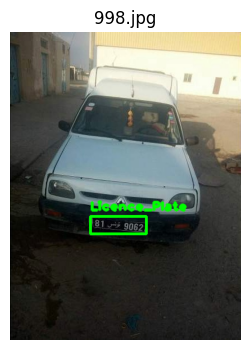

In [9]:
# Function for visualising bounding box on license plate

img_path = f'/Users/velmurugan/Desktop/@/python_works/License plate detection/test/{ran_num}.jpg'

def show_bbox(img_path):

    image = cv2.imread(img_path)

    results = License_plate_model(image)[0]

    threshold = 0.5

    for result in results.boxes.data.tolist():
        x1,y1,x2,y2, score, class_id = result

        if score>=threshold:
            # Draw bounding box
            cv2.rectangle(image,(int(x1),int(y1)),(int(x2),int(y2)),(0,255,0),4)

            # Write label text above the bounding box
            cv2.putText(image,results.names[int(class_id)],(int(x1),int(y1-10)),
                        fontFace = cv2.FONT_HERSHEY_PLAIN, fontScale= 1.5, color=(0,255,0),
                        thickness=3, lineType=cv2.LINE_AA)

    # Convert the image from BGR to RGB format for Matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the image with bounding boxes and labels using Matplotlib
    plt.figure(figsize=(10, 4))
    plt.imshow(image_rgb)
    plt.title(f'{ran_num}.jpg')
    plt.axis('off')  # Hide axes for better visualization
    plt.show() 

show_bbox(img_path)

In [10]:
# Function to perform detection and extract license plate regions
def detect_and_crop(model, image_path):
    image = Image.open(image_path)
    results = model(image)[0]
    crops = []
    for *box, conf, cls in results.boxes.data.tolist():  # Iterate through detections
        xmin, ymin, xmax, ymax = map(int, box)
        cropped_img = image.crop((xmin, ymin, xmax, ymax))
        crops.append(cropped_img)
    return crops

In [50]:
test_dir = '/Users/velmurugan/Desktop/@/python_works/License plate detection/test'
output_dir = '/Users/velmurugan/Desktop/@/python_works/License plate detection/cropped_images'


cropped_images = []

# First detect the License plate for given test dataset 
# And save the cropped license plate to process further recognition analysis

for image in os.listdir(test_dir):
    img_path = os.path.join(test_dir,image)
    cropped_images.extend(detect_and_crop(License_plate_model, img_path))
    for cropped_image in cropped_images:
        cropped_image.save(os.path.join(output_dir,image))
    


0: 384x640 1 Licence_Plate, 85.1ms
Speed: 4.1ms preprocess, 85.1ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 640x480 1 Licence_Plate, 69.9ms
Speed: 1.3ms preprocess, 69.9ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 480)

0: 480x640 1 Licence_Plate, 68.8ms
Speed: 1.4ms preprocess, 68.8ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 1 Licence_Plate, 56.6ms
Speed: 1.2ms preprocess, 56.6ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 640x576 1 Licence_Plate, 87.2ms
Speed: 1.7ms preprocess, 87.2ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 576)

0: 640x480 1 Licence_Plate, 74.8ms
Speed: 1.7ms preprocess, 74.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)

0: 448x640 1 Licence_Plate, 65.6ms
Speed: 1.5ms preprocess, 65.6ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 Licence_Plate, 69.2ms
Speed: 1.4ms preprocess, 69.2ms i

In [121]:
for cropped_image in cropped_images:
    cropped_image.save(output_dir)

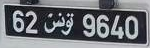

In [58]:
cropped_images[28]

In [11]:
# Import the label csv to perform recognition task

license_label = pd.read_csv('/Users/velmurugan/Desktop/@/python_works/License plate detection/Licplatesrecognition_train.csv')
license_label.head()

,img_id,text
0,0.jpg,117T3989
1,1.jpg,128T8086
2,10.jpg,94T3458
3,100.jpg,133T6719
4,101.jpg,68T5979


In [13]:
license_label.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   img_id  900 non-null    object
 1   text    900 non-null    object
dtypes: object(2)
memory usage: 14.2+ KB


In [12]:
# img_id column is not sorted
# Apply the function to create a new column for sorting
license_label['img_id_numeric'] = license_label['img_id'].apply(extract_numeric_part)

# Sort the DataFrame based on the numeric column
license_label = license_label.sort_values(by='img_id_numeric')

# Drop the numeric column it is not needed
license_label = license_label.drop(columns='img_id_numeric')

license_label.reset_index(drop=True, inplace=True)

print(license_label.head(3))
license_label.tail(3)

  img_id      text
0  0.jpg  117T3989
1  1.jpg  128T8086
2  2.jpg  170T6123


,img_id,text
897,907.jpg,162T9979
898,908.jpg,115T5367
899,910.jpg,106T2131


In [13]:
# We need to extract only numerical values from the license plate
# Function to remove non-numeric characters from text column

def preprocess_label(label):
    return re.sub(r'[^0-9]', '', label)

# Apply the preprocessing function to the label column
license_label['text'] = license_label['text'].apply(preprocess_label)

# Display the first few rows of the data to verify the changes
print(license_label.head())

  img_id     text
0  0.jpg  1173989
1  1.jpg  1288086
2  2.jpg  1706123
3  3.jpg  1031643
4  4.jpg   621040


In [14]:
# Splitting the dataset for training and testing 

train_df = license_label.iloc[:870]
val_df = license_label.iloc[870:]
train_img_path = '/Users/velmurugan/Desktop/@/python_works/License plate detection/reco/train'
val_img_path = '/Users/velmurugan/Desktop/@/python_works/License plate detection/reco/val'

In [15]:
# Defining a custom class for the image dataset 

class LicensePlateDataset(Dataset):
    def __init__(self, df, root_dir, transform=None,max_label_length=10):
        self.data_frame = df
        self.root_dir = root_dir
        self.transform = transform
        
        # Output column has varying length so we have to pad the values
        self.max_label_length = max_label_length

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.data_frame.iloc[idx, 0])

        image = cv2.imread(img_name, cv2.IMREAD_GRAYSCALE) # Convering to image to graysclale
        image = cv2.resize(image, (128, 32)) # Cropped image 
        
        if self.transform:
            image = self.transform(image)
        
        
        # Label processing
        label = self.data_frame.iloc[idx, 1]
        label = self.encode_label(label)
        
        return image, torch.tensor(label, dtype=torch.long)
    
    
    def encode_label(self, label):
        # Convert label string to a list of integers (character indices)
        label = [ord(char) - ord('0') for char in label]
        # Pad the label in the front to max_label_length
        if len(label) < self.max_label_length:
            label = [0] * (self.max_label_length - len(label)) + label
        return label


# Define any transformations if needed
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])


train_dataset = LicensePlateDataset(df=train_df, root_dir=train_img_path, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

test_dataset = LicensePlateDataset(df=val_df,root_dir=val_img_path,transform=transform)
test_dataloader = DataLoader(test_dataset,batch_size=16,shuffle=False)

# Checking one sample from the dataset
sample_image, sample_label = train_dataset[0]
print(sample_image.shape, sample_label)


torch.Size([1, 32, 128]) tensor([0, 0, 0, 1, 1, 7, 3, 9, 8, 9])


In [ ]:
'''data_transforms = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])'''

In [18]:
train_dataset.__getitem__(1)

(tensor([[[-0.1216,  0.4039,  0.2627,  ...,  0.8824,  0.8118,  0.8902],
          [ 0.1216,  0.3804, -0.0275,  ...,  0.6627,  0.6706,  0.7255],
          [ 0.1529,  0.3569, -0.0353,  ...,  0.3569,  0.4980,  0.5373],
          ...,
          [ 0.0588, -0.1686,  0.0980,  ..., -0.0588,  0.1529,  0.0353],
          [ 0.1373, -0.1608,  0.0980,  ..., -0.0667,  0.1608,  0.0353],
          [ 0.1843, -0.1765,  0.0588,  ..., -0.0588,  0.1529,  0.0353]]]),
 tensor([0, 0, 0, 1, 2, 8, 8, 0, 8, 6]))

In [19]:
len(train_dataloader)

55

In [3]:
# Defining the architecture of the CRNN model
# Since the previous model tend to overfit, now I perform dropout

class CRNN(nn.Module):
    def __init__(self, img_height, num_channels, num_classes, rnn_hidden_size=256):
        super(CRNN, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 64x64x16
            nn.Dropout(0.25),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 128x32x8
            nn.Dropout(0.25),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 256x16x4
            nn.Dropout(0.25),
        )

        self.rnn = nn.LSTM(256 * (img_height // 8), rnn_hidden_size, bidirectional=True, num_layers=2, batch_first=True, dropout=0.5)
        self.fc = nn.Linear(rnn_hidden_size * 2, num_classes)

    def forward(self, x):
        cnn_out = self.cnn(x)
        batch_size, channels, height, width = cnn_out.size()
        cnn_out = cnn_out.permute(0, 3, 1, 2).contiguous()
        cnn_out = cnn_out.view(batch_size, width, channels * height)
        rnn_out, _ = self.rnn(cnn_out)
        output = self.fc(rnn_out)
        return output


img_height = 32
num_channels = 1  # grayscale images
num_classes = 10  # 10 digits 

model = CRNN(img_height=img_height, num_channels=num_channels, num_classes=num_classes)
print(model)


CRNN(
  (cnn): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.25, inplace=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.25, inplace=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Dropout(p=0.25, inplace=False)
  )
  (rnn): LSTM(1024, 256, num_layers=2, batch_fir

In [52]:
# Defining the epochs,Optimizer and Loss function
num_epochs = 75
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
criterion = nn.CrossEntropyLoss() 

for epoch in range(num_epochs):
    model.train()
    for i, (images, labels) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outputs = model(images)
        
        # Calculate loss
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        if i % 50 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i}/{len(train_dataloader)}], Loss: {loss.item():.4f}")

print("Training complete!")

Epoch [1/75], Step [0/55], Loss: 0.2161
Epoch [1/75], Step [50/55], Loss: 0.1625
Epoch [2/75], Step [0/55], Loss: 0.2161
Epoch [2/75], Step [50/55], Loss: 0.2494
Epoch [3/75], Step [0/55], Loss: 0.2004
Epoch [3/75], Step [50/55], Loss: 0.1582
Epoch [4/75], Step [0/55], Loss: 0.2635
Epoch [4/75], Step [50/55], Loss: 0.2232
Epoch [5/75], Step [0/55], Loss: 0.1404
Epoch [5/75], Step [50/55], Loss: 0.1496
Epoch [6/75], Step [0/55], Loss: 0.1390
Epoch [6/75], Step [50/55], Loss: 0.1744
Epoch [7/75], Step [0/55], Loss: 0.0910
Epoch [7/75], Step [50/55], Loss: 0.1239
Epoch [8/75], Step [0/55], Loss: 0.1239
Epoch [8/75], Step [50/55], Loss: 0.1181
Epoch [9/75], Step [0/55], Loss: 0.0956
Epoch [9/75], Step [50/55], Loss: 0.1993
Epoch [10/75], Step [0/55], Loss: 0.1114
Epoch [10/75], Step [50/55], Loss: 0.1524
Epoch [11/75], Step [0/55], Loss: 0.0679
Epoch [11/75], Step [50/55], Loss: 0.1347
Epoch [12/75], Step [0/55], Loss: 0.1418
Epoch [12/75], Step [50/55], Loss: 0.1106
Epoch [13/75], Step [0

In [5]:
model_path = '/Users/velmurugan/Desktop/@/python_works/License plate detection/model.pkl'


In [58]:
# saving the trained model
'''with open(model_path,'wb') as f:
    pickle.dump(model,f)'''

In [6]:
# Loading the trained model

with open(model_path,'rb') as f:
    loaded_model = pickle.load(f)

In [19]:
# Function to evaluate the trained model

def evaluate_model(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in data_loader:
            
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            preds = preds.view(-1).numpy()
            labels = labels.view(-1).numpy()

            all_preds.extend(preds) #predictions
            all_labels.extend(labels) #Ground_truths
    
    # Evaluation metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")


In [22]:
# Evaluation on test data
evaluate_model(loaded_model,test_dataloader)

Accuracy: 0.8567
Precision: 0.8606
Recall: 0.8567
F1 Score: 0.8566


In [28]:
# Get the image and label
image, label = test_dataset.__getitem__(17)
print("Label:", label)

# Set the model to evaluation mode
model.eval()

with torch.no_grad():
    # Unsqueeze the image tensor to add batch dimension
    image = image.unsqueeze(0)  # Shape: [1, channels, height, width]
    
    # Get the model output
    pred = loaded_model(image)
    
    
    # Get the index of the max log-probability
    _, predicted = torch.max(pred, dim=1)
    print("Predicted:", predicted)

Label: tensor([0, 0, 0, 0, 6, 2, 3, 9, 2, 7])
Predicted: tensor([[0, 0, 0, 0, 6, 2, 2, 9, 2, 7]])


Trained model works fine!
Predicting the Cropped Test data

In [ ]:
cropped_dir = '/Users/velmurugan/Desktop/@/python_works/License plate detection/cropped_images'

results = []

for image_name in os.listdir(cropped_dir):
    # Take each image, do preprocess and predict the charaters in it 
    image_path = os.path.join(cropped_dir,image_name)
    
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)    
    image = cv2.resize(image, (128, 32))
    transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])
    image = transform(image)

    pred = loaded_model(image.unsqueeze(0))
    # Get the index of the max log-probability
    _, predicted = torch.max(pred, dim=1)
    predicted = predicted[0].tolist()

    results.append((image_name,predicted))

In [8]:
# Results are in unsorted manner
# Function to extract numerical part from the image name for sorting

def extract_number(image_name):
    match = re.search(r'(\d+)', image_name)
    return int(match.group(1)) if match else 0

results = sorted(results, key= lambda x:extract_number(x[0]))
results[:10]

[('901.jpg', [0, 0, 0, 1, 6, 9, 9, 6, 8, 5]),
 ('902.jpg', [0, 0, 0, 1, 2, 9, 2, 2, 7, 5]),
 ('903.jpg', [0, 0, 0, 1, 1, 1, 2, 7, 9, 9]),
 ('904.jpg', [0, 0, 0, 1, 2, 2, 6, 3, 2, 4]),
 ('905.jpg', [0, 0, 0, 1, 2, 0, 8, 9, 1, 7]),
 ('906.jpg', [0, 0, 0, 1, 7, 5, 2, 7, 2, 0]),
 ('907.jpg', [0, 0, 0, 0, 7, 5, 6, 5, 5, 8]),
 ('908.jpg', [0, 0, 0, 1, 7, 7, 4, 7, 1, 2]),
 ('909.jpg', [0, 0, 0, 0, 8, 0, 4, 2, 6, 7]),
 ('910.jpg', [0, 0, 0, 0, 8, 9, 3, 1, 8, 7])]

In [12]:
#removing the padded zeros

for name, val in results:
    val.pop(0)
    val.pop(0)
    val.pop(0)

In [13]:
results[:10]

[('901.jpg', [1, 6, 9, 9, 6, 8, 5]),
 ('902.jpg', [1, 2, 9, 2, 2, 7, 5]),
 ('903.jpg', [1, 1, 1, 2, 7, 9, 9]),
 ('904.jpg', [1, 2, 2, 6, 3, 2, 4]),
 ('905.jpg', [1, 2, 0, 8, 9, 1, 7]),
 ('906.jpg', [1, 7, 5, 2, 7, 2, 0]),
 ('907.jpg', [0, 7, 5, 6, 5, 5, 8]),
 ('908.jpg', [1, 7, 7, 4, 7, 1, 2]),
 ('909.jpg', [0, 8, 0, 4, 2, 6, 7]),
 ('910.jpg', [0, 8, 9, 3, 1, 8, 7])]

In [14]:
# Function to transform data as per sample submission.csv

def transform_data(data):
    binary = [0]*10
    transformed_data = []

    for name,values in data:
        for i,val in enumerate(values):
            image_name = 'img_'+name.split('.')[0]+'_'+str(i+1) #img_901_1
            binary[val] = 1
            transformed_data.append([image_name] + binary)
            binary = [0]*10

    return transformed_data

# Apply the transformation
transformed_data = transform_data(results)

# Print the transformed data

for i,row in enumerate(transformed_data):
    print(row)
    if i == 13:
        break


['img_901_1', 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
['img_901_2', 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
['img_901_3', 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
['img_901_4', 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
['img_901_5', 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
['img_901_6', 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
['img_901_7', 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
['img_902_1', 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
['img_902_2', 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
['img_902_3', 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
['img_902_4', 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
['img_902_5', 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
['img_902_6', 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
['img_902_7', 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]


In [ ]:
# File name to save the transformed data
output_file = '/Users/velmurugan/Desktop/@/python_works/License plate detection/Submission.csv'

# Write to CSV file
with open(output_file, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['id', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])  # Header row
    writer.writerows(transformed_data)

print(f"Data saved to {output_file}")


In [48]:
result_df = pd.read_csv(output_file)
result_df

,id,0,1,2,3,4,5,6,7,8,9
0,img_901_1,0,1,0,0,0,0,0,0,0,0
1,img_901_2,0,0,0,0,0,0,1,0,0,0
2,img_901_3,0,0,0,0,0,0,0,0,0,1
3,img_901_4,0,0,0,0,0,0,0,0,0,1
4,img_901_5,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1465,img_1113_3,1,0,0,0,0,0,0,0,0,0
1466,img_1113_4,0,0,0,0,0,1,0,0,0,0
1467,img_1113_5,0,0,0,1,0,0,0,0,0,0
1468,img_1113_6,0,0,0,1,0,0,0,0,0,0
